trying to upsample using smote

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd ../gdrive/MyDrive/hw1ml/

In [ ]:
%ls


develop on local environment

In [ ]:
# Install useful stuff
! apt install --yes ssh screen nano htop ranger git > /dev/null
# SSH setting
! echo "root:carbonara" | chpasswd
! echo "PasswordAuthentication yes" > /etc/ssh/sshd_config
! echo "PermitUserEnvironment yes" >> /etc/ssh/sshd_config
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! service ssh restart > /dev/null
# Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
# Run ngrok
authtoken = "20Apljvp3ViVnx3mzPGy8RN3VFt_4bzufXGF9Kkgm43PmRugS"
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
! sleep 3
# Get the address for SSH
import requests
from re import sub
r = requests.get('http://localhost:4040/api/tunnels')
str_ssh = r.json()['tunnels'][0]['public_url']
str_ssh = sub("tcp://", "", str_ssh)
str_ssh = sub(":", " -p ", str_ssh)
str_ssh = "ssh root@" + str_ssh
print(str_ssh)

use once you open the notebook

In [ ]:
%cd ../hw1ml

In [ ]:
!pip install shutup

In [ ]:

##At the top of the code
import shutup;
shutup.please()

function to print metrics and confusion matrix given a model to fit

In [325]:
def classificationResults(x_train,x_test,y_train,y_test,models):
    if type(models) is not list:
        models=[models]
    y_train=y_train[:,0]
    y_test=y_test[:,0]

    for model in models:
        print(f"the model is {model}")
        model.fit(x_train,y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        print("train report")
        print(classification_report(y_train, y_pred_train))
        print("test report")
        print(classification_report(y_test, y_pred_test))
        print("\nConfusion Matrix test:")

        cm = confusion_matrix(y_test, y_pred_test)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot()
        print("\n\n\n")

function to print the metrix given a model to fit

In [ ]:
def regressionResults(x_train,x_test,y_train,y_test,models,sample_weight=None):
    if type(models) is not list:
        models=[models]
    y_train=y_train[:,1]
    y_test=y_test[:,1]
    for model in models:
        print(f"the model is {model}")
        model.fit(x_train,y_train)
        y_pred_train=model.predict(x_train)
        y_pred_test=model.predict(x_test)
        print("Train MSE: ",np.mean((y_train-y_pred_train)**2))
        print("Train MAE: ",np.mean(np.abs(y_train-y_pred_train)))
        print("Test MSE: ",np.mean((y_test-y_pred_test)**2))
        print("Test MAE: ",np.mean(np.abs(y_test-y_pred_test)))
        print("\n\n\n")
    

read the dataset

In [320]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import random
import warnings

#make everything reproducible
random.seed(50)
np.random.seed(50)


dataset=pd.read_csv("train_set.tsv", sep='\t', header=0)
dataset_numpy=dataset.to_numpy()
x=dataset_numpy[:,:-2]
y=dataset_numpy[:,-2:]



add new features

In [314]:
print(f"shape before {x.shape}")
for i in range(0, x.shape[1],7):
    distance_x=x[:,i+1]-x[:,i+5]
    distance_y=x[:,i+2]-x[:,i+6]
    cosine_north=np.cos(x[:,i])
    x=np.append(x, np.array([distance_x]).T, axis=1)
    x=np.append(x, np.array([distance_y]).T, axis=1)
    x=np.append(x, np.array([cosine_north]).T, axis=1)
print(f"shape after {x.shape}")  



shape before (1000, 35)
shape after (1000, 50)


use the minmax scaler

In [321]:
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler.fit(x)
x=scaler.transform(x)

use the standard scaler

In [ ]:
scaler = StandardScaler()
scaler.fit(x)
x=scaler.transform(x)


if you want to normalize the data

In [ ]:
from sklearn.preprocessing import normalize
x=normalize(x)

trying to use pca features

In [ ]:

from sklearn.decomposition import PCA

pca = PCA(n_components=4)
x = pca.fit_transform(x)

trying to descretize


In [ ]:
from sklearn.preprocessing import KBinsDiscretizer


trying to extract nonlinear features

In [ ]:
from sklearn.preprocessing import QuantileTransformer
x=QuantileTransformer().fit_transform(x)

split the dataset

In [322]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y,random_state=45)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)
print(f"the classes and the number of occurrences in the train set are {np.unique(y_train[:,0], return_counts=True)}")
print(f"the classes and the number of occurrences in the test set are {np.unique(y_test[:,0], return_counts=True)}")

(750, 35) (750, 2) (250, 35) (250, 2)
the classes and the number of occurrences in the train set are (array([0., 1., 2., 3., 4.]), array([399, 246,  79,  23,   3], dtype=int64))
the classes and the number of occurrences in the test set are (array([0., 1., 2., 3.]), array([139,  87,  17,   7], dtype=int64))


compute class weights

In [ ]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train[:,0]), 
    y=y_train[:,0]
    )
class_weight=dict(enumerate(class_weights))
sample_weight=np.array([class_weight[y_train[i,0]] for i in range(y_train.shape[0])])
class_weight

use smota with a mix of under and over sampling

In [323]:
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# over_sampler = RandomOverSampler(sampling_strategy={1:300,2:150,3:50})
# under_sampler = RandomUnderSampler(sampling_strategy={0:100,1:100})
smote=SMOTE(random_state=100,sampling_strategy={0:1000,1:1000,2:1000,3:1000})

# x_train,y_train=under_sampler.fit_resample(x_train,y_train[:,0])
# x_train,y_train=over_sampler.fit_resample(x_train,y_train)
x_train,y_train=smote.fit_resample(x_train,y_train[:,0])

y_train=y_train.reshape(-1,1)
print(f"the classes and the number of occurrences in the train set are {np.unique(y_train, return_counts=True)}")

the classes and the number of occurrences in the train set are (array([0., 1., 2., 3., 4.]), array([1000, 1000, 1000, 1000,    3], dtype=int64))


to deal with unbalanced dataset one could try to undersple the overrapresented classes but here since the dataset is not big it doesn't work

In [ ]:
#if you want to undersample the data doenst work because i've not too much data 
from imblearn.under_sampling import RandomUnderSampler
over_sampler = RandomUnderSampler(random_state=42,sampling_strategy={0:74,1:74})
x_train, y_train = over_sampler.fit_resample(x_train, y_train[:,0])
y_train=y_train.reshape(-1,1)
print(x_train.shape,y_train.shape)
print(f"the classes and the number of occurrences are {np.unique(y_train[:,0], return_counts=True)}")

to deal with the unbalanced dataset one could try to oversample the underrepresentad classes but here since the dataset is not big it doesn't work

In [ ]:
#if you want to oversample i dont think it's a good idea because i've not too much data 
from imblearn.over_sampling import RandomOverSampler
over_sampler = RandomOverSampler(random_state=42,sampling_strategy={2:100})
x_train, y_train = over_sampler.fit_resample(x_train, y_train[:,0])
y_train=y_train.reshape(-1,1)
print(x_train.shape,y_train.shape)
print(f"the classes and the number of occurrences are {np.unique(y_train[:,0], return_counts=True)}")


the model is DecisionTreeClassifier()
train report
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1000
         1.0       1.00      1.00      1.00      1000
         2.0       1.00      1.00      1.00      1000
         3.0       1.00      1.00      1.00      1000
         4.0       1.00      1.00      1.00         3

    accuracy                           1.00      4003
   macro avg       1.00      1.00      1.00      4003
weighted avg       1.00      1.00      1.00      4003

test report
              precision    recall  f1-score   support

         0.0       0.56      0.37      0.44       139
         1.0       0.33      0.38      0.35        87
         2.0       0.07      0.18      0.10        17
         3.0       0.00      0.00      0.00         7

    accuracy                           0.35       250
   macro avg       0.24      0.23      0.22       250
weighted avg       0.43      0.35      0.38       250


Confusion Ma

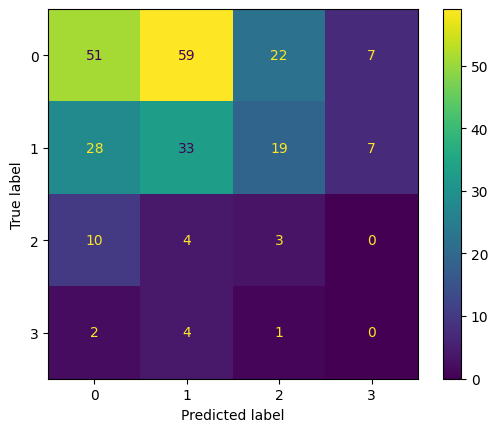

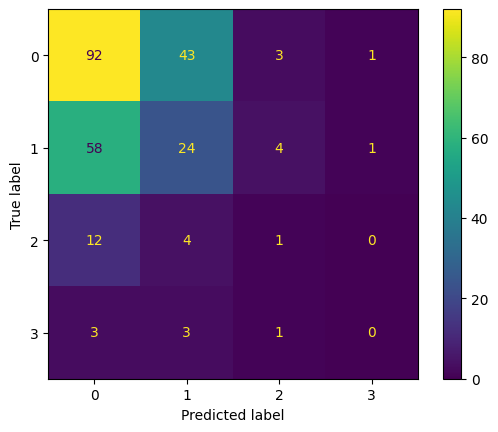

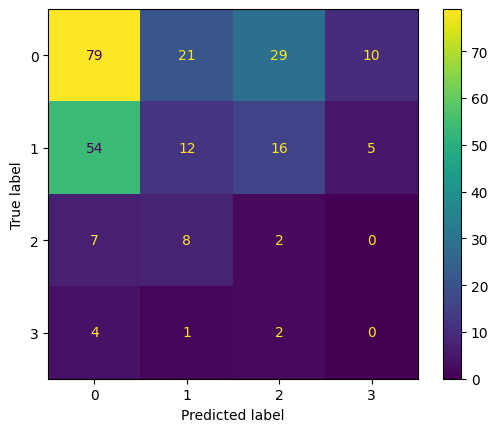

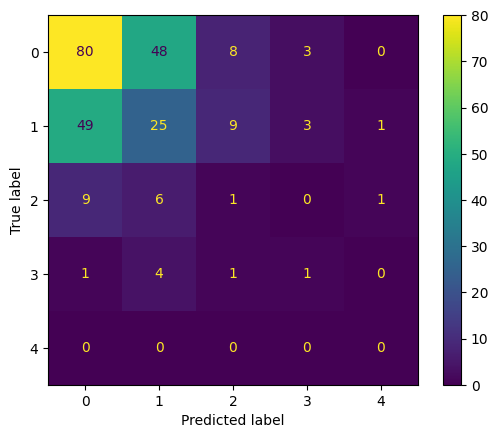

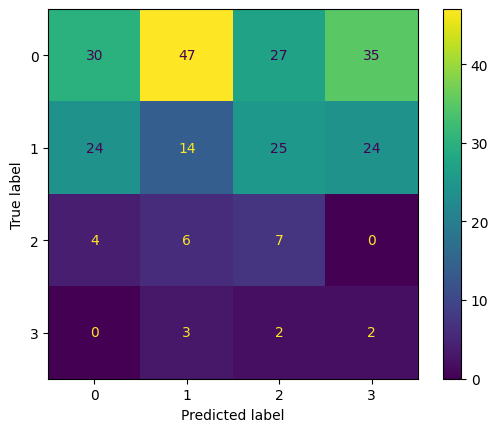

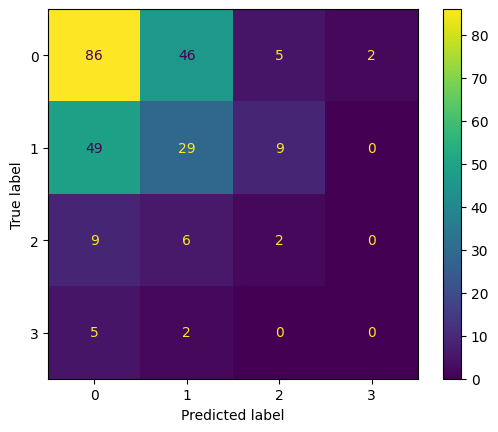

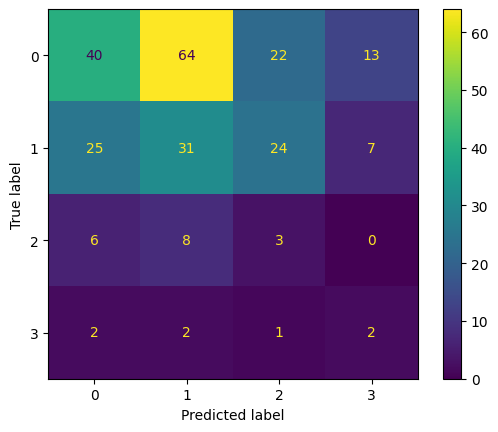

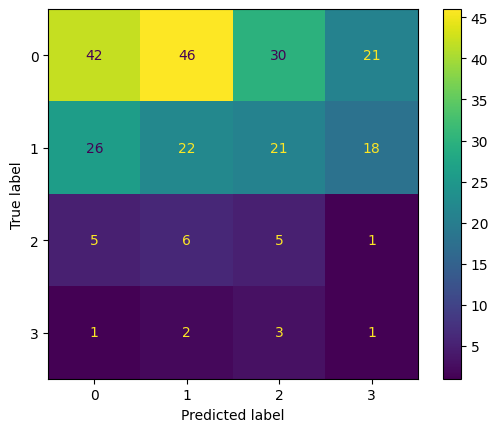

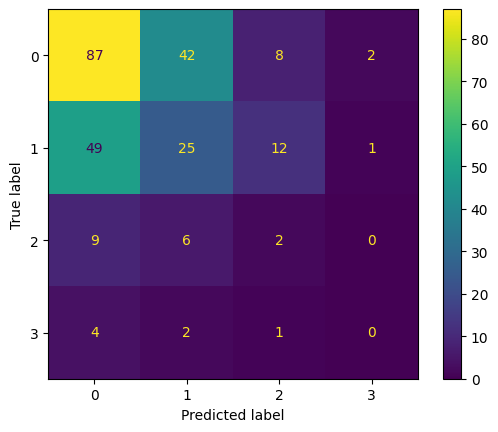

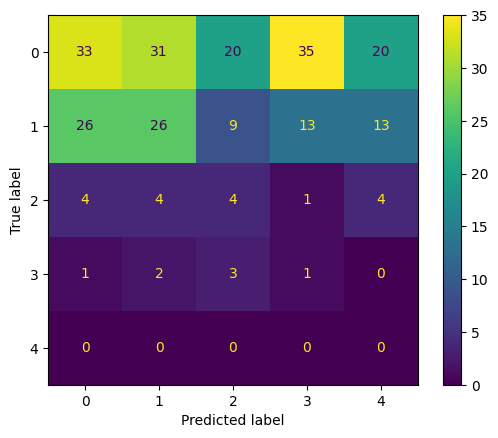

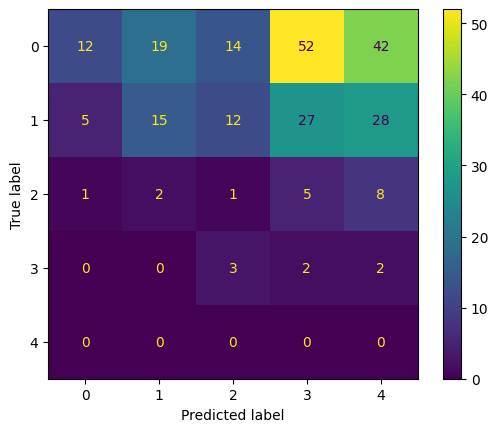

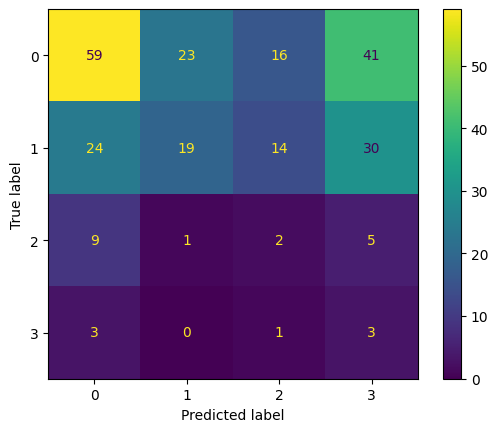

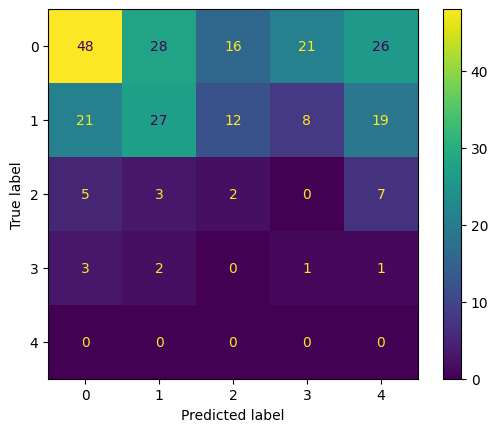

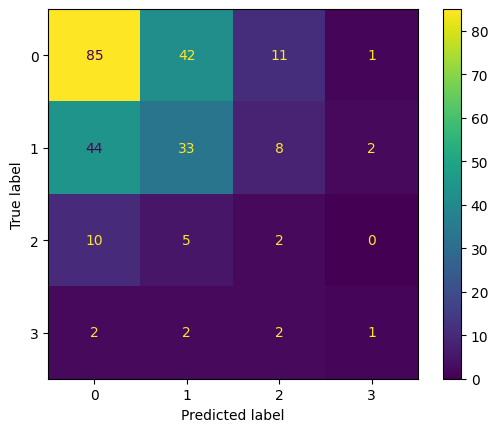

In [324]:
#test all classification models
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import BaggingClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.ensemble import RUSBoostClassifier
from imblearn.ensemble import EasyEnsembleClassifier
#import mlp classifier
from sklearn.neural_network import MLPClassifier

models=[
tree.DecisionTreeClassifier(),
RandomForestClassifier(),
AdaBoostClassifier(),
GradientBoostingClassifier(),
LogisticRegression(),
SVC(),
KNeighborsClassifier(),
GaussianNB(),
BaggingClassifier(),
BalancedBaggingClassifier(base_estimator=tree.DecisionTreeClassifier(),sampling_strategy='auto',replacement=False,random_state=0),
BalancedRandomForestClassifier(n_estimators=100,random_state=0),
RUSBoostClassifier(),
EasyEnsembleClassifier(),
MLPClassifier()]

classificationResults(x_train,x_test,y_train,y_test,models)


In [ ]:
# import random parametes search
from sklearn.model_selection import RandomizedSearchCV
#random hyperparameters search for svm 
model= SVC()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf', 'linear', 'poly', 'rbf', 'linear'],
                'degree':[1,2,3,4,5,6,7,8,9,10],
                'class_weight':['balanced',None],
                'decision_function_shape':['ovo','ovr']
                }
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs = -1)
random_search.fit(x_train, y_train[:,0])
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
# classificationResults(x_train,x_test,y_train,y_test,random_search.best_estimator_)




In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters={
    'n_estimators': [50,70,100,120],
    "max_depth": range(2,20),
    "criterion": ["gini", "entropy"],
    "min_samples_leaf"=range(1,10),
    "min_samples_split": range(1,10),
    "max_features": ["auto", "sqrt", "log2"]
    "class_weight":['balanced',None]
    }
model=RandomForestClassifier()

clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train[:,0])

print(clf.best_params_)
print(clf.best_score_)


In [ ]:
#test all regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
models=[RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),\
LinearRegression(),SVR(),KNeighborsRegressor(),DecisionTreeRegressor()]
regressionResults(x_train,x_test,y_train,y_test,models)

In [ ]:
# import random parametes search
from sklearn.model_selection import RandomizedSearchCV
#random hyperparameters search for svm 
model= SVC()

param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
                'kernel': ['rbf', 'linear', 'poly', 'rbf', 'linear'],
                'degree':[1,2,3,4,5,6,7,8,9,10],
                'class_weight':['balanced',None],
                'decision_function_shape':['ovo','ovr']
                }
random_search = RandomizedSearchCV(model, param_grid, n_iter=10, cv=5, verbose=2, random_state=42, n_jobs = -1)
random_search.fit(x_train, y_train[:,0])
print(random_search.best_params_)
print(random_search.best_score_)
print(random_search.best_estimator_)
# classificationResults(x_train,x_test,y_train,y_test,random_search.best_estimator_)




In [ ]:

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
parameters={
    'n_estimators': [50,70,100,120],
    "max_depth": range(2,20),
    "criterion": ["gini", "entropy"],
    "min_samples_leaf"=range(1,10),
    "min_samples_split": range(1,10),
    "max_features": ["auto", "sqrt", "log2"]
    "class_weight":['balanced',None]
    }
model=RandomForestClassifier()

clf = GridSearchCV(model, parameters)
clf.fit(x_train, y_train[:,0])

print(clf.best_params_)
print(clf.best_score_)


In [ ]:
model=RandomForestClassifier(class_weight=class_weight)
classificationResults(x_train,x_test,y_train,y_test,model)

In [ ]:
model=RandomForestClassifier(class_weight='balanced')
classificationResults(x_train,x_test,y_train,y_test,model)

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn import svm
# parameters={'kernel':('linear', 'poly' ,"rbf","sigmoid"),'gamma':["scale","auto"],'class_weight':[None,"balanced"]}


# model=svm.SVC()

# clf = GridSearchCV(model, parameters)
# clf.fit(x_train, y_train[:,0])

# print(clf.best_params_)
# print(clf.best_score_)


In [ ]:
# from sklearn.ensemble import AdaBoostClassifier
# model=AdaBoostClassifier()
# print(f" those are the parameters to optimize {model.get_params()}")
# parameters={"n_estimators":[10,5,20,50,100,200,500,1000],"learning_rate":[0.01,0.001,0.0001,0.05,0.1,0.2,0.5,1]}
# clf = GridSearchCV(model, parameters)
# clf.fit(x_train, y_train[:,0])

# print(clf.best_params_)
# print(clf.best_score_)


In [ ]:
#test all regression models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
models=[RandomForestRegressor(),AdaBoostRegressor(),GradientBoostingRegressor(),\
LinearRegression(),SVR(),KNeighborsRegressor(),DecisionTreeRegressor()]
regressionResults(x_train,x_test,y_train,y_test,models)